<a href="https://colab.research.google.com/github/manteshswami/Flower-Classification-Using-VGG16-Transfer-Learning/blob/main/Transfer_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping


In [2]:
import os
import tarfile
import urllib.request

url="https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
dataset_dir="flower_photos"
tgz_path="flower_photos.tgz"

if not os.path.exists(tgz_path):
    print("Downloading flower dataset...")
    urllib.request.urlretrieve(url, tgz_path)
    print("Download Completed")

if not os.path.exists(dataset_dir):
    print("Extracting flower dataset...")
    with tarfile.open(tgz_path, 'r:gz') as tar:
        tar.extractall()
    print("Extraction Completed")

print("Available classes:",os.listdir(dataset_dir))



Available classes: ['roses', 'LICENSE.txt', 'daisy', 'dandelion', 'sunflowers', 'tulips']


In [3]:
from sklearn.model_selection import train_test_split
import shutil

original_dir="flower_photos"
bash_dir="dataset"
os.makedirs(bash_dir, exist_ok=True)

for class_name in os.listdir(original_dir):
    class_path=os.path.join(original_dir, class_name)
    if not os.path.isdir(class_path):
        continue

    images = os.listdir(class_path)
    train, temp = train_test_split(images, test_size=0.2, random_state=42)
    val, test = train_test_split(temp, test_size=0.5, random_state=42)

    for split, split_data in zip(['train', 'val', 'test'], [train, val, test]):
        split_path = os.path.join(bash_dir, split, class_name)
        os.makedirs(split_path, exist_ok=True)

        for image in split_data:
            shutil.copy(os.path.join(class_path, image), os.path.join(split_path, image))


In [4]:
import os
from PIL import Image
from collections import defaultdict

def count_images_and_check_dims(root_dir):
    print(f"\nScanning directory: {root_dir}")

    class_counts = defaultdict(int)
    dimensions = []

    for class_name in os.listdir(root_dir):
        class_path = os.path.join(root_dir, class_name)
        if not os.path.isdir(class_path):
            continue

        for image_name in os.listdir(class_path):
            image_path = os.path.join(class_path, image_name)
            try:
                with Image.open(image_path) as img:
                    class_counts[class_name] += 1
                    # (Width, Height, Channels)
                    dimensions.append(img.size + (len(img.getbands()),))
            except Exception as e:
                print(f"Error processing {image_path}: {e}")

    print("\nImage Counts per Class:")
    for class_name, count in class_counts.items():
        print(f"{class_name}: {count} images")

    return dimensions


# Example usage
print("=== Train Folder ===")
train_dims = count_images_and_check_dims("dataset/train")

print("\n=== Validation Folder ===")
val_dims = count_images_and_check_dims("dataset/val")

print("\n=== Test Folder ===")
test_dims = count_images_and_check_dims("dataset/test")


=== Train Folder ===

Scanning directory: dataset/train

Image Counts per Class:
roses: 512 images
daisy: 506 images
dandelion: 718 images
sunflowers: 559 images
tulips: 639 images

=== Validation Folder ===

Scanning directory: dataset/val

Image Counts per Class:
roses: 64 images
daisy: 63 images
dandelion: 90 images
sunflowers: 70 images
tulips: 80 images

=== Test Folder ===

Scanning directory: dataset/test

Image Counts per Class:
roses: 65 images
daisy: 64 images
dandelion: 90 images
sunflowers: 70 images
tulips: 80 images


### Setting the image Directory paths with Data Augmentation

In [5]:
from numpy.random.mtrand import shuffle
train_dir = "dataset/train"
val_dir = "dataset/val"
test_dir = "dataset/test"

img_size=(160,160)
batch_size = 32
num_classes = len(os.listdir(train_dir))

train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,horizontal_flip=True,zoom_range=0.2)
val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

Found 2934 images belonging to 5 classes.
Found 367 images belonging to 5 classes.
Found 369 images belonging to 5 classes.


## Define The Model Architecture

In [15]:
base_model=VGG16(weights='imagenet', include_top=False, input_shape=(160,160,3))

In [16]:
base_model.summary()  ## only feature extraction

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 160, 160, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 160, 160, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 80, 80, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 80, 80, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 80, 80, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 40, 40, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 40, 40, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 40, 40, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 40, 40, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 20, 20, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 20, 20, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 20, 20, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 20, 20, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 10, 10, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 10, 10, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 10, 10, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 10, 10, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 5, 5, 512)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

In [17]:
base_model.layers[:-3]

[<InputLayer name=input_layer_1, built=True>,
 <Conv2D name=block1_conv1, built=True>,
 <Conv2D name=block1_conv2, built=True>,
 <MaxPooling2D name=block1_pool, built=True>,
 <Conv2D name=block2_conv1, built=True>,
 <Conv2D name=block2_conv2, built=True>,
 <MaxPooling2D name=block2_pool, built=True>,
 <Conv2D name=block3_conv1, built=True>,
 <Conv2D name=block3_conv2, built=True>,
 <Conv2D name=block3_conv3, built=True>,
 <MaxPooling2D name=block3_pool, built=True>,
 <Conv2D name=block4_conv1, built=True>,
 <Conv2D name=block4_conv2, built=True>,
 <Conv2D name=block4_conv3, built=True>,
 <MaxPooling2D name=block4_pool, built=True>,
 <Conv2D name=block5_conv1, built=True>]

In [18]:
for layer in base_model.layers:
    layer.trainable=False
    print(layer)

<InputLayer name=input_layer_1, built=True>
<Conv2D name=block1_conv1, built=True>
<Conv2D name=block1_conv2, built=True>
<MaxPooling2D name=block1_pool, built=True>
<Conv2D name=block2_conv1, built=True>
<Conv2D name=block2_conv2, built=True>
<MaxPooling2D name=block2_pool, built=True>
<Conv2D name=block3_conv1, built=True>
<Conv2D name=block3_conv2, built=True>
<Conv2D name=block3_conv3, built=True>
<MaxPooling2D name=block3_pool, built=True>
<Conv2D name=block4_conv1, built=True>
<Conv2D name=block4_conv2, built=True>
<Conv2D name=block4_conv3, built=True>
<MaxPooling2D name=block4_pool, built=True>
<Conv2D name=block5_conv1, built=True>
<Conv2D name=block5_conv2, built=True>
<Conv2D name=block5_conv3, built=True>
<MaxPooling2D name=block5_pool, built=True>


In [19]:
base_model.input

<KerasTensor shape=(None, 160, 160, 3), dtype=float32, sparse=False, ragged=False, name=keras_tensor_23>

In [20]:
base_model.output

<KerasTensor shape=(None, 5, 5, 512), dtype=float32, sparse=False, ragged=False, name=keras_tensor_41>

In [21]:
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 160, 160, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 160, 160, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 80, 80, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 80, 80, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 80, 80, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 40, 40, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 40, 40, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 40, 40, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 40, 40, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 20, 20, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 20, 20, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 20, 20, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 20, 20, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 10, 10, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 10, 10, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 10, 10, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 10, 10, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 5, 5, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 5)              │         1,285 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,847,301 (56.64 MB)

 Trainable params: 132,613 (518.02 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

### Let's Start the Training

In [22]:
callback = [
    EarlyStopping(patience=3,restore_best_weights=True),
    ModelCheckpoint("vgg16_best_model.h5", save_best_only=True)
]

history=model.fit(train_generator, epochs=10, validation_data=val_generator, callbacks=callback)

Epoch 1/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 10s/step - accuracy: 0.2640 - loss: 7.6131 

92/92 ━━━━━━━━━━━━━━━━━━━━ 1068s 12s/step - accuracy: 0.2646 - loss: 7.5982 - val_accuracy: 0.5504 - val_loss: 2.1290
Epoch 2/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 10s/step - accuracy: 0.4607 - loss: 3.5879

92/92 ━━━━━━━━━━━━━━━━━━━━ 1029s 11s/step - accuracy: 0.4611 - loss: 3.5846 - val_accuracy: 0.6649 - val_loss: 1.4639
Epoch 3/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 10s/step - accuracy: 0.5676 - loss: 2.5392

92/92 ━━━━━━━━━━━━━━━━━━━━ 984s 11s/step - accuracy: 0.5677 - loss: 2.5374 - val_accuracy: 0.7275 - val_loss: 1.1743
Epoch 4/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 10s/step - accuracy: 0.6371 - loss: 1.9090

92/92 ━━━━━━━━━━━━━━━━━━━━ 1049s 11s/step - accuracy: 0.6371 - loss: 1.9089 - val_accuracy: 0.7439 - val_loss: 1.0257
Epoch 5/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 10s/step - accuracy: 0.6515 - loss: 1.6544

92/92 ━━━━━━━━━━━━━━━━━━━━ 1003s 11s/step - accuracy: 0.6517 - loss: 1.6534 - val_accuracy: 0.7575 - val_loss: 0.9339
Epoch 6/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 10s/step - accuracy: 0.6941 - loss: 1.3704

92/92 ━━━━━━━━━━━━━━━━━━━━ 1042s 11s/step - accuracy: 0.6941 - loss: 1.3700 - val_accuracy: 0.7684 - val_loss: 0.8704
Epoch 7/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 10s/step - accuracy: 0.7022 - loss: 1.1756

92/92 ━━━━━━━━━━━━━━━━━━━━ 992s 11s/step - accuracy: 0.7022 - loss: 1.1751 - val_accuracy: 0.7629 - val_loss: 0.8220
Epoch 8/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 10s/step - accuracy: 0.7214 - loss: 1.0674

92/92 ━━━━━━━━━━━━━━━━━━━━ 1019s 11s/step - accuracy: 0.7215 - loss: 1.0674 - val_accuracy: 0.7711 - val_loss: 0.7818
Epoch 9/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 10s/step - accuracy: 0.7345 - loss: 0.9881

92/92 ━━━━━━━━━━━━━━━━━━━━ 1027s 11s/step - accuracy: 0.7346 - loss: 0.9876 - val_accuracy: 0.7793 - val_loss: 0.7398
Epoch 10/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 10s/step - accuracy: 0.7549 - loss: 0.8585

92/92 ━━━━━━━━━━━━━━━━━━━━ 1026s 11s/step - accuracy: 0.7548 - loss: 0.8587 - val_accuracy: 0.7738 - val_loss: 0.7127


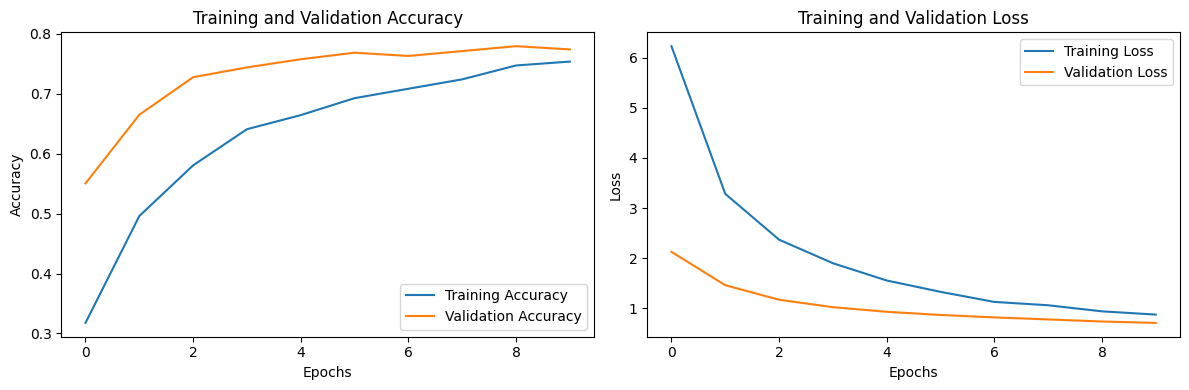

In [28]:
### Accuracy & Loss Graphs

def plot_history(history):
    plt.figure(figsize=(12, 4))
    ## Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    ## Loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_history(history)

In [29]:
def predict_image(image_path):
  img=load_img(image_path, target_size=img_size)
  plt.imshow(img)
  plt.axis('off')
  img_array=img_to_array(img)
  img_array=np.expand_dims(img_array, axis=0)
  img_array=preprocess_input(img_array)
  prediction=model.predict(img_array)
  predicted_class=np.argmax(prediction)
  class_names=list(train_generator.class_indices.keys())
  print(f"Predicted Class: {class_names[predicted_class]}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   
Predicted Class: daisy


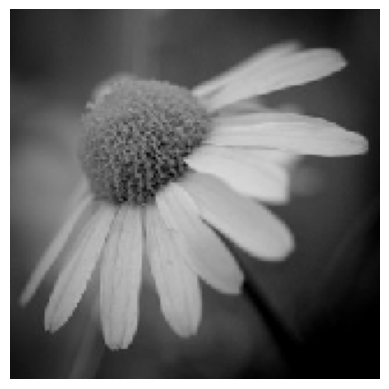

In [34]:
predict_image("/content/flower_photos/daisy/10437770546_8bb6f7bdd3_m.jpg")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 309ms/step
Predicted Class: roses


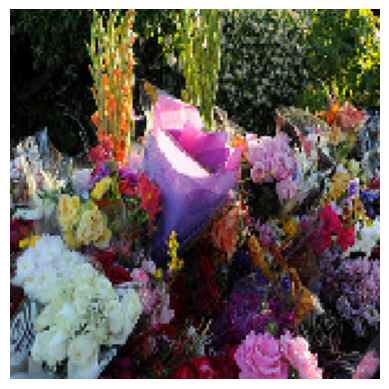

In [36]:
predict_image("/content/flower_photos/roses/10894627425_ec76bbc757_n.jpg")